In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [19]:
train_dir = r"C:\Users\Admin\Desktop\emo\archive\train"
test_dir = r"C:\Users\Admin\Desktop\emo\archive\test"

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

In [21]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [22]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),  # Smaller image size
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.


In [23]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False  # Ensures consistent validation results
)

Found 7178 images belonging to 7 classes.


In [28]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')  # 7 output classes
])

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('quick_emotion_model.keras', save_best_only=True)


In [34]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Automatically adjusts to dataset size
    validation_data=test_generator,
    validation_steps=len(test_generator),  # Automatically adjusts to dataset size
    epochs=5,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 80s 355ms/step - accuracy: 0.3551 - loss: 1.6499 - val_accuracy: 0.3997 - val_loss: 1.5654
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 79s 351ms/step - accuracy: 0.3778 - loss: 1.6091 - val_accuracy: 0.4181 - val_loss: 1.5363
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 95s 424ms/step - accuracy: 0.3859 - loss: 1.5843 - val_accuracy: 0.4214 - val_loss: 1.4980
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 95s 417ms/step - accuracy: 0.3914 - loss: 1.5685 - val_accuracy: 0.4195 - val_loss: 1.4982
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - accuracy: 0.3982 - loss: 1.5446 - val_accuracy: 0.4260 - val_loss: 1.4768


In [35]:
model.save('quick_emotion_model.keras')

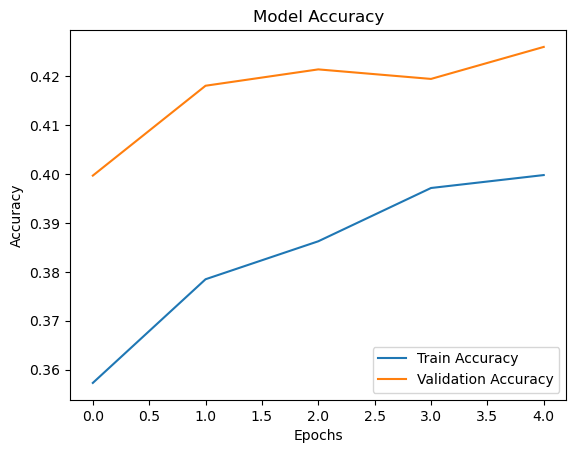

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained model
emotion_model = load_model('emotion_model.keras')
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Start the webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert frame to grayscale for consistency with training data
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        # Draw rectangle around face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
        # Preprocess the detected face for the model
        roi_gray = gray_frame[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        roi_gray = roi_gray / 255.0
        roi_gray = np.expand_dims(roi_gray, axis=0)
        roi_gray = np.expand_dims(roi_gray, axis=-1)
        
        # Predict emotion
        predictions = emotion_model.predict(roi_gray)
        emotion_index = np.argmax(predictions)
        emotion_label = emotion_labels[emotion_index]
        
        # Display the emotion label
        cv2.putText(frame, emotion_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Display the video feed
    cv2.imshow('Emotion Detector', frame)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/